## Section 1: Load Data and Data Preparation

In this section, the aims are to load the dataset, produce the predictor variables derived from the variables in our data frame, and perform outlier analysis:

* This will be done by visualising the data using bar charts, boxplots, and histograms.

In this section, you will see the creation of our variables and the steps taken to produce them:

1. Creation of the `Age` and `Current_condition` variables.
2. A visualisation depicting the distribution of the `AverageDaily`, `Age`, and `Trucks_percent` variables.
3. Creation of the DataFrame by reducing categories and setting variable thresholds to exclude outliers and historical values.

### Section 1.1: Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Section 1.2: Introducing the Data Set

* In This section we provide a brief descripiton of all of the variables as well as types of each of the variables as well a brief descriptor of the Current Condition rating 


| Variable      |      Description             | Type | 
|:--------------|:-----------------------------|:------:|
|Structure_id   | Unique identifier of the bridge                  | String |
|District       | Highway district in Texas responsible for bridge | category | 
|Detour_Km      | Length of detour if bridge closed                | continuous |
|Toll           | Whether a toll is paid to use bridge             | category |
|Maintainer     | The authority responsible for maintenance        | category |
|Urban          | Whether the bridge is located in an urban or rural area   | category |
|Status         | The road class: interstate to local                       | category | 
|Year           | The year the bridge was built                             | continuous | 
|Lanes_on       | The number of lanes that run over the bridge              | continuous (or discrete) |
|Lanes_under    | The number of lanes that run under the bridge             | continuous (or discrete) |
|AverageDaily   | The average daily traffic (number of vehicles)            | continuous |
|Future_traffic | The estimated daily traffic in approx 20 years time       | continuous |
|Trucks_percent | The percent of traffic made up of 'trucks' (i.e. lorries) | continuous |
|Historic       | Whether the bridge is historic                            | category | 
|Service_under  | The (most important) service that runs under the bridge   | category |
|Material       | The dominant material the bridge is made from             | category |
|Design         | The design of the bridge                                  | category |
|Spans          | The number of spans the bridge has                        | category (or discrete) |
|Length         | The length of the bridge in metres                        | continuous |
|Width          | The width of the bridge in metres                         | continuous |
|Rated_load     | The rated max loading of bridge (in tonnes)               | continuous |
|Scour_rating   | Only for bridges over water: the 'scour' condition        | ordinal |
|Deck_rating    | The condition of the deck of the bridge                   | ordinal |
|Superstr_rating| The condition of the bridge superstructure                | ordinal |
|Substr_rating  | The condition of the bridge substructure (foundations)    | ordinal |

#### Current Condition Rating Descriptor

| Rating | Description |
|:-----------|:------------------------|
| 0 |Failed|
| 1 |Failing|
| 2 |Critical|
| 3 |Serious| 
| 4 |Poor| 
| 5 |Fair| 
| 6 |Satisfactory| 
| 7 |Good| 
| 8 |Very Good| 
| 9 |Excellent| 
 

### Section 1.2: Loading the Data

In this section, the aim is to load the data frame:

* When loading the data frame, we will call it `bridges` and set the index column as `Structure_id` to allow us to select the information for a specific bridge.
* This will be done using a type map, which will allow us to set the types of the variables.
* This will be carried out for `Deck_rating`, `Superstr_rating`, and `Substr_rating` using the `pd.CategoricalDtype` function.


In [2]:
rating_type = pd.CategoricalDtype(
    categories=['Good', 'Very Good', 'Fair', 'Satisfactory', 'Excellent', 'Failed',
       'Poor', 'NA', 'Failing', 'Serious', 'Critical'],
    ordered=True)

types_dict = { 'Structure_id': str, 'District':'category', 'Toll':'category', 
              'Maintainer':'category', 'Urban':'category', 'Status':'category', 
              'Historic':'category', 'Service_under':'category', 'Material': 'category', 
              'Design':'category', 
              'Deck_rating':rating_type, 'Superstr_rating':rating_type, 'Substr_rating':rating_type}

bridges = pd.read_csv('tx19_bridges_sample.csv', dtype = types_dict, index_col = 'Structure_id')
bridges.head()

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,2,31.4,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,1,15.5,4.3,Good,Good,Very Good,41.7,0.0,Dry,1
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,1,10.1,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150
000021525-00012,District2,199,Free,Agency,Rural,Local,1950,1,0,80,...,14,45.4,3.7,Good,Good,Poor,10.0,0.0,Dry,120
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,1,25.0,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200


### Section 1.3: Derivation of Variables and Reduction in Categories

In this section, the aim is to derive the `Age` and `Current_condition` variables, as well as reduce the number of categories in the `Design` and `Material` variables:

* We also check for the presence of any **NaN** values 

* We derive the `Age` variable by subtracting the year the bridge was built from the current year (2024).

* To reduce the number of categories, we initially found the count for each category in each variable using the `.value_counts()` function. After inspection, it was decided that, due to the comparatively low counts for the `Other` and `Masonry` categories, we would combine them under the name `Other`.

* For `Design`, we combined the `Movable`, `Suspension`, `Frame`, `Arch`, and `Truss` categories under the name `Other`, to be grouped with the already existing `Other` categories, as they are quite small.

* To derive the `Current_condition` variable, we will assign the rating categories a value ranging from 0 to 9, with 0 = Failed and 9 = Excellent. We derive this variable using the ratings given to each bridge from the `Deck_rating`, `Superstr_rating`, and `Substr_rating`, assigning a numerical value to each category. This will allow us to calculate the average value for each bridge, which will become the `Current_condition` variable.

In [3]:
bridges.loc[(bridges.Deck_rating.isnull()) | (bridges.Superstr_rating.isnull()) ]

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Spans,Length,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic
Structure_id,,,,,,,,,,,,,,,,,,,,,
010920004518118,District1,0,Free,State,Rural,Arterial,1970,2,2,7520,...,1,42.7,12.2,NaN,Good,Good,32.7,2.0,No waterway,10530
021200AA0205001,District2,11,Free,County,Rural,Local,1946,1,0,340,...,1,17.7,3.9,Good,NaN,Fair,11.8,0.0,Stable,390
031690AA0273001,District3,5,Free,County,Rural,Local,2008,2,0,20,...,1,12.2,7.2,NaN,Very Good,Very Good,32.7,0.0,Dry,40
121020B37610001,District12,2,Free,Town or City,Urban,Local,2008,2,0,100,...,1,15.2,8.2,NaN,Good,Good,32.7,0.0,Stable,150
131580AA0323001,District13,159,Free,County,Rural,Local,1999,1,0,60,...,1,8.5,6.0,NaN,Very Good,Good,32.7,0.0,Dry,100
190190102001006,District19,10,Free,State,Rural,Minor,1991,2,0,160,...,4,67.1,9.1,NaN,Good,Good,32.7,16.0,Dry,230
211090AA0348002,District21,6,Free,County,Rural,Local,1960,2,0,50,...,3,11.0,5.5,Failing,NaN,Poor,0.0,0.0,Stable,30


* Above we checked for **NaN** values in our dataset due to the fact there are only 7 rows containing **NaN** values, we have chosen to ignore them as they will not have a signifcant impact on the results of our analysis.

In [4]:
bridges['Age'] = 2024 - bridges['Year']

Text(0.5, 0, 'Design Type')

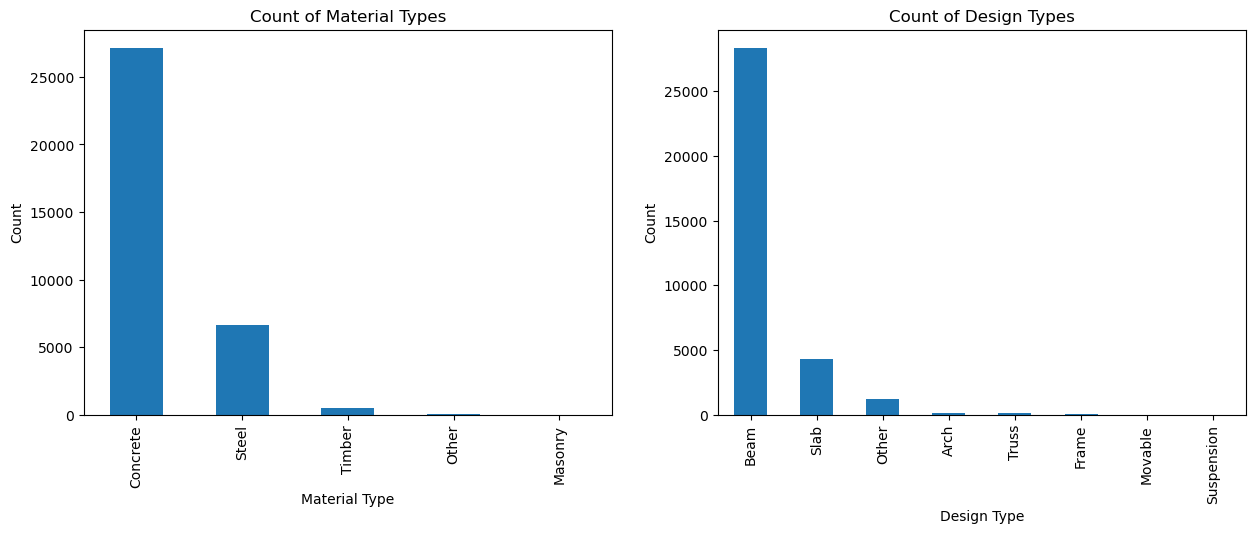

In [5]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(15,5))

bridges['Material'].value_counts().plot(kind='bar', ax=a1)
bridges['Design'].value_counts().plot(kind='bar', ax=a2)

fig.suptitle('')
[a.set_title('') for a in [a1, a2]]

a1.set_title('Count of Material Types')
a1.set_ylabel('Count')
a1.set_xlabel('Material Type')

a2.set_title('Count of Design Types')
a2.set_ylabel('Count')
a2.set_xlabel('Design Type')


In [6]:
bridges['Material'] = bridges['Material'].replace('Masonry','Other')
bridges['Material'] = bridges['Material'].replace('Timber', 'Other')
bridges['Design'] = bridges['Design'].replace('Movable', 'Other')
bridges['Design'] = bridges['Design'].replace('Suspension', 'Other')
bridges['Design'] = bridges['Design'].replace('Frame', 'Other')
bridges['Design'] = bridges['Design'].replace('Truss', 'Other')
bridges['Design'] = bridges['Design'].replace('Arch', 'Other')

/var/folders/15/1_wklszx7252qmvrxtpkhgzm0000gn/T/ipykernel_23355/2735630810.py:1: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bridges['Material'] = bridges['Material'].replace('Masonry','Other')
/var/folders/15/1_wklszx7252qmvrxtpkhgzm0000gn/T/ipykernel_23355/2735630810.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  bridges['Material'] = bridges['Material'].replace('Timber', 'Other')
/var/folders/15/1_wklszx7252qmvrxtpkhgzm0000gn/T/ipykernel_23355/2735630810.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is

Text(0.5, 0, 'Design Type')

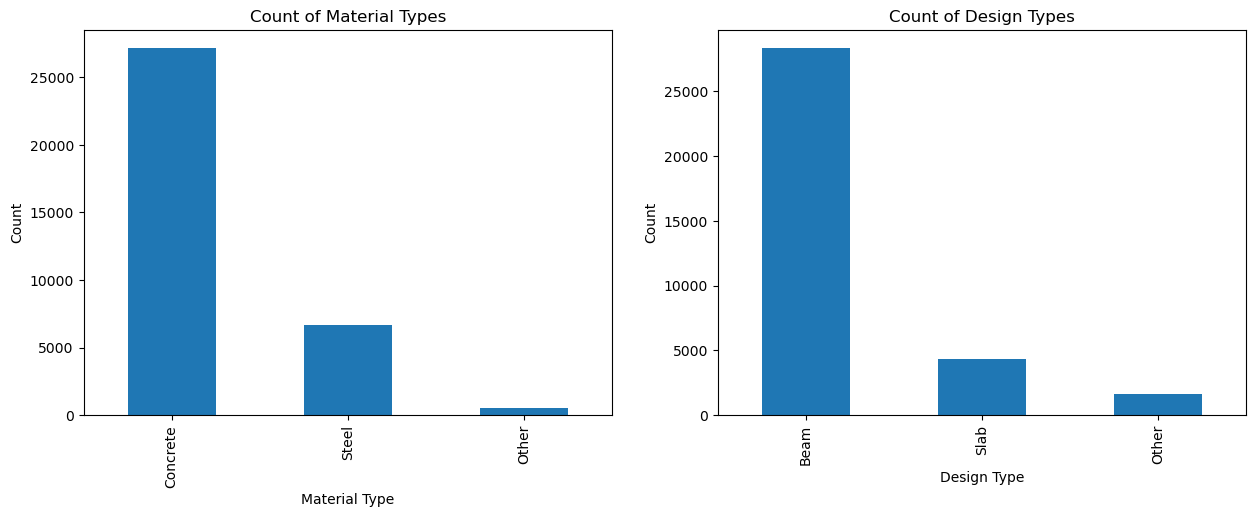

In [7]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(15,5))

bridges['Material'].value_counts().plot(kind='bar', ax=a1)
bridges['Design'].value_counts().plot(kind='bar', ax=a2)

fig.suptitle('')
[a.set_title('') for a in [a1, a2]]

a1.set_title('Count of Material Types')
a1.set_ylabel('Count')
a1.set_xlabel('Material Type')

a2.set_title('Count of Design Types')
a2.set_ylabel('Count')
a2.set_xlabel('Design Type')

In [8]:
current_condition_rating = pd.CategoricalDtype(categories=['Failed','Failing', 'Critical', 'Serious','Poor', 'Fair', 'Satisfactory',
'Good', 'Very Good', 'Excellent'], ordered=True)

simp_d = {'Failed':0, 'Failing':1, 'Critical':2, 
          'Serious':3, 'Poor':4, 'Fair':5, 'Satisfactory':6, 'Good':7, 'Very Good':8, 'Excellent':9}


def simDRating(row):
    score = 0
    
    score += simp_d.get(row.Deck_rating, 0)
    score += simp_d.get(row.Superstr_rating, 0)
    score += simp_d.get(row.Substr_rating, 0)
    score = score/3
    return round(score,2)


bridges['Current_condition'] = bridges.apply(simDRating, axis=1)

### Section 1.4: Outlier Detection

In this section, the aim is to detect the presence of outliers within our dataset.

* To conduct the relevant analysis, I have employed the use of box plots and histograms. Using the information gained from these visualisations, I have set thresholds on `Age`, `AverageDaily`, and `Trucks_percent` to limit the proliferation of outliers in our dataset.

* Justifications for why these thresholds were set will be explained after the plots.

Text(0, 0.5, 'Trucks Percent')

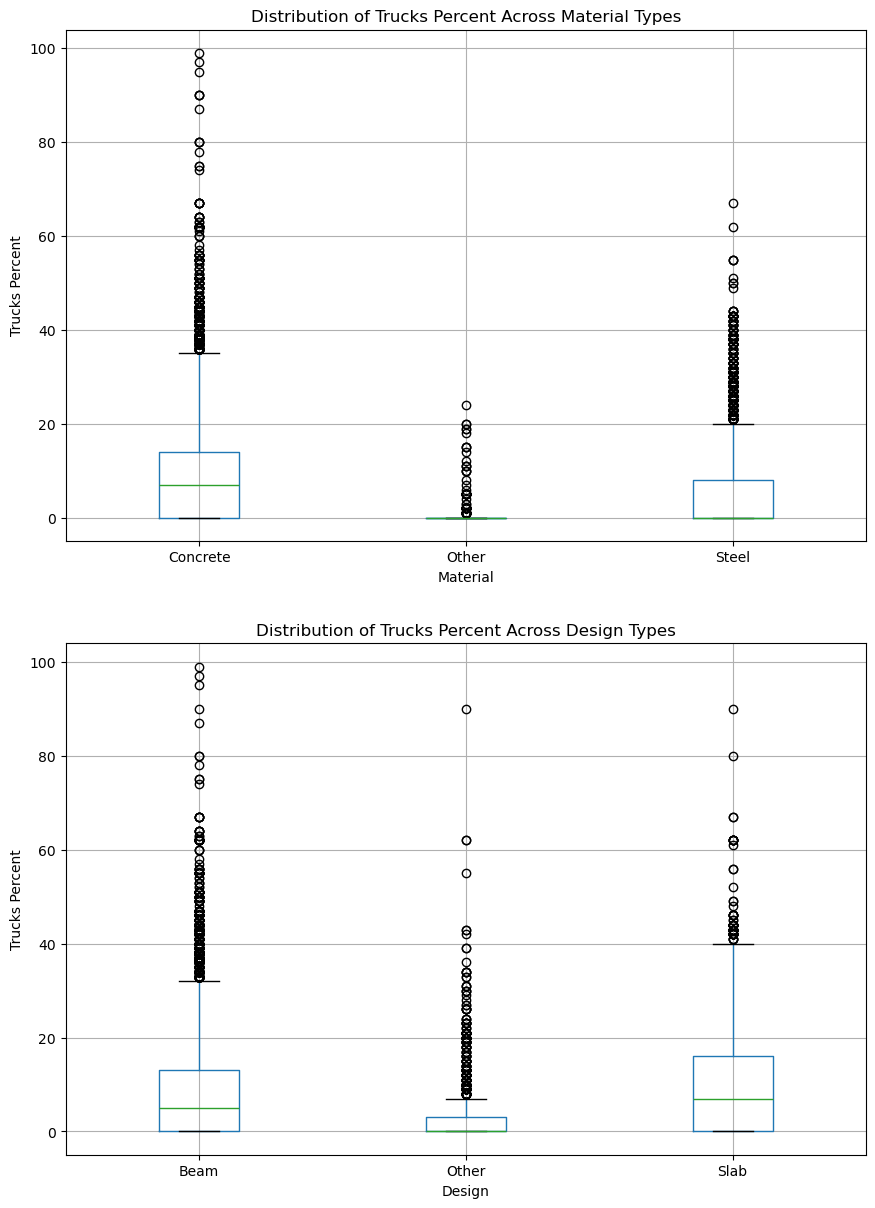

In [9]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(10,15))


bridges.boxplot(column='Trucks_percent', by='Material', ax=a1)
bridges.boxplot(column='Trucks_percent', by='Design', ax=a2)

fig.suptitle('')
[a.set_title('') for a in [a1, a2]]

a1.set_title('Distribution of Trucks Percent Across Material Types')
a1.set_ylabel('Trucks Percent')
a2.set_title('Distribution of Trucks Percent Across Design Types')
a2.set_ylabel('Trucks Percent')


Text(0, 0.5, 'Average Daily')

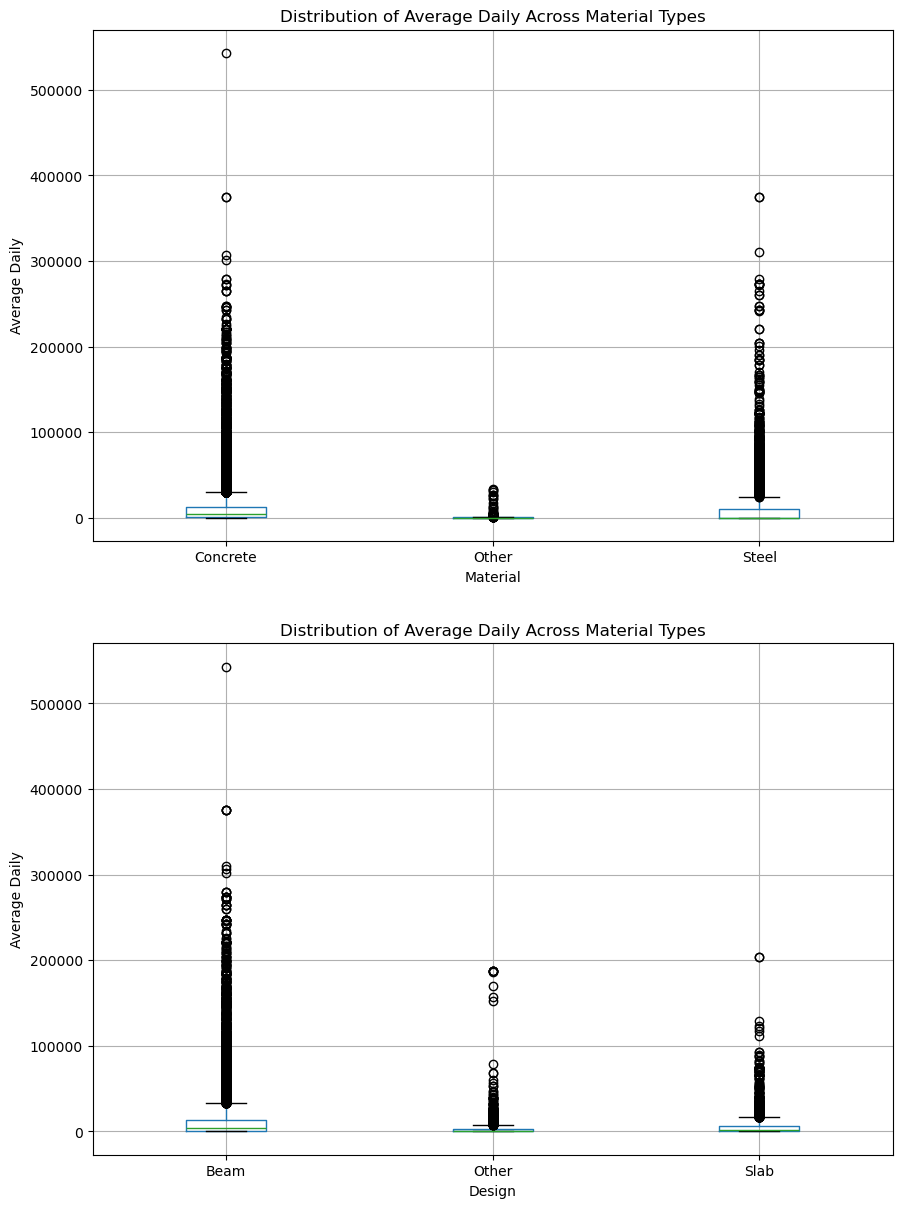

In [10]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(10,15))

bridges.boxplot(column='AverageDaily', by='Material', ax=a1)
bridges.boxplot(column='AverageDaily', by='Design', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]

a1.set_title('Distribution of Average Daily Across Material Types')
a1.set_ylabel('Average Daily')
a2.set_title('Distribution of Average Daily Across Material Types')
a2.set_ylabel('Average Daily')

Text(0, 0.5, 'Age')

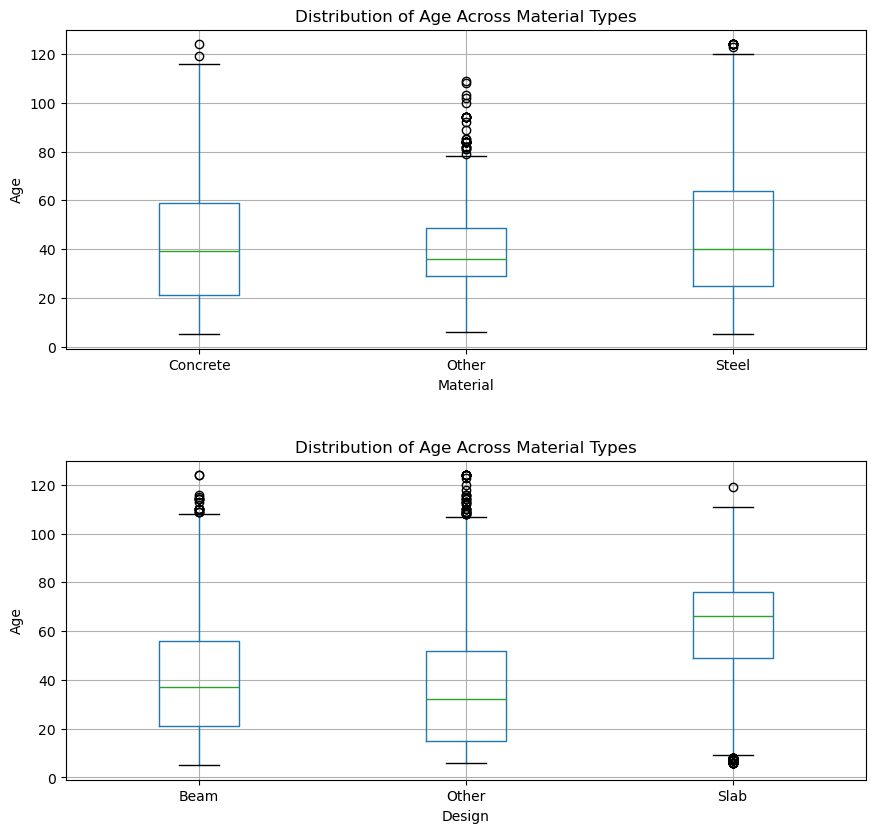

In [11]:
fig, (a1, a2) = plt.subplots(2,1, figsize=(10,10))
fig.subplots_adjust(hspace=0.35)

bridges.boxplot(column='Age', by='Material', ax=a1)
bridges.boxplot(column='Age', by='Design', ax=a2)

# Make the plots a bit clearer
fig.suptitle('')
[a.set_title('') for a in [a1, a2]]

a1.set_title('Distribution of Age Across Material Types')
a1.set_ylabel('Age')
a2.set_title('Distribution of Age Across Material Types')
a2.set_ylabel('Age')

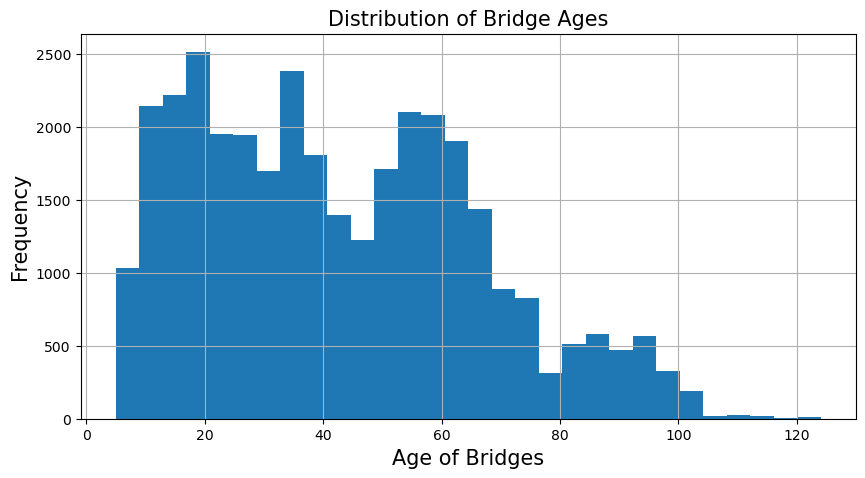

In [12]:
bridges.hist(column='Age', bins=30, figsize=(10, 5))

plt.xlabel('Age of Bridges', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of Bridge Ages', fontsize=15)
plt.show()

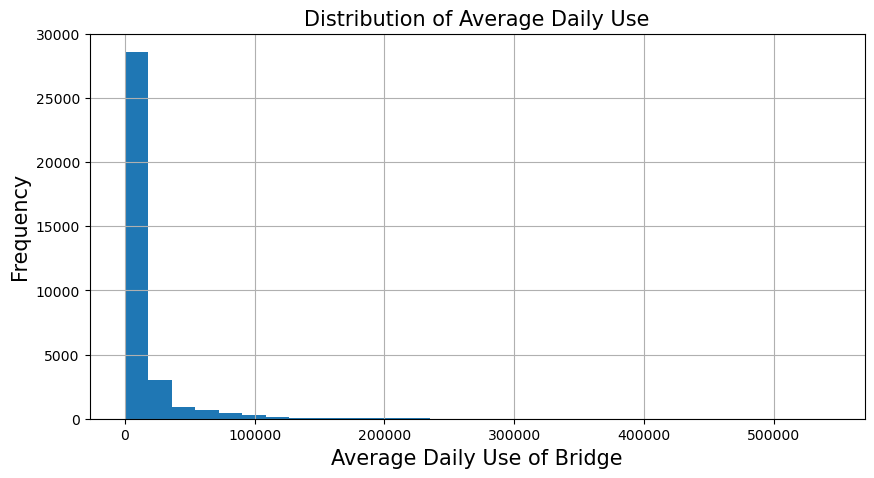

In [13]:
bridges.hist(column='AverageDaily', bins=30, figsize=(10,5))

plt.xlabel('Average Daily Use of Bridge', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of Average Daily Use', fontsize=15)
plt.show()

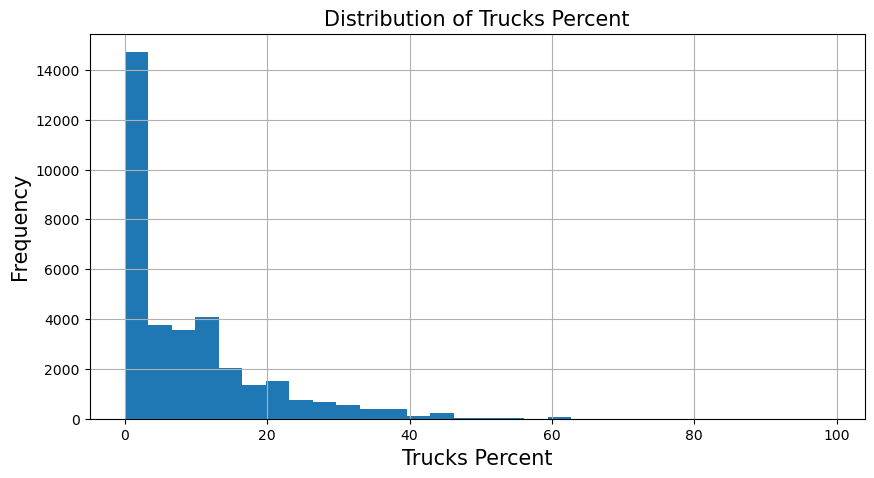

In [14]:
bridges.hist(column='Trucks_percent', bins=30, figsize=(10,5))

plt.xlabel('Trucks Percent', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.title('Distribution of Trucks Percent', fontsize=15)
plt.show()

* When looking at the box plot for the `Age` variable across the design and material categories, we initially see a large proliferation of points that exceed the maximum value visualised by the box plot. Due to this large number of data points, I have assumed that these are extreme but relevant values. Applying this principle to the `Trucks_percent` variable as well, I decided to set thresholds at the approximate point where the extreme values begin to dissipate, as I have determined that these values are natural variations in the dataset and therefore should not be excluded.

* The distribution of `Trucks_percent` and `AverageDaily` is positively skewed, which further reinforces the assumption stated above and has influenced my approximation of where to set the threshold values to exclude outlier values.

* When considering the removal of historic bridges, we examined a box plot that indicates the presence of outliers. This is further reinforced when looking at the distribution of ages; after approximately 70 years, the frequency of bridges reduces significantly. Therefore, we may assume that bridges older than 70 years are historic and should be excluded from our analysis.

* For the categorical variables `Material` and `Design`, I have combined the smaller categories within these variables into one category. As highlighted by the visualisations showing the count of bridges in each category, I thought it important to merge these categories to streamline the analysis by reducing the number of categories.


In [15]:
bridges = bridges.loc[(bridges.Age < 70) & (bridges.AverageDaily < 200000) & (bridges.Trucks_percent < 70)]
bridges.head()

,District,Detour_Km,Toll,Maintainer,Urban,Status,Year,Lanes_on,Lanes_under,AverageDaily,...,Width,Deck_rating,Superstr_rating,Substr_rating,Rated_load,Trucks_percent,Scour_rating,Future_traffic,Age,Current_condition
Structure_id,,,,,,,,,,,,,,,,,,,,,
000021521-00101,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,4.3,Good,Very Good,Very Good,41.7,0.0,Dry,1,19,7.67
000021521-00181,District2,199,Free,Agency,Rural,Local,2005,1,0,1,...,4.3,Good,Good,Very Good,41.7,0.0,Dry,1,19,7.33
000021521-TMP20,District2,199,Free,Agency,Rural,Local,2012,2,0,100,...,8.4,Very Good,Very Good,Very Good,48.1,0.0,Dry,150,12,8.00
000021580-00092,District2,6,Free,Agency,Rural,Local,2004,2,0,150,...,7.3,Good,Very Good,Very Good,37.2,4.0,Dry,200,20,7.67
000021580-00093,District2,3,Free,Agency,Rural,Local,2005,2,0,150,...,8.5,Very Good,Very Good,Very Good,49.9,4.0,Dry,200,19,8.00


* In the code above we have prepared our data and are applying value thresholds to exclude historic bridges but to also exclude outlier values that we have determined as not being truly representative of the dataset.

## Section 2: Exploratory Analysis

In this section, the aim is to explore the relationship of our predictor variables and the target variable:

* This is to be done by exploring the relationship of the categorical variables to one another as we will be looking to see if there is a correlation between them.
* We will also explore the relationship between the continous variables as well.
* Finally we will explore to see if there is a significant relationship between the categrorical and continous variables as well.


### Section 2.1 Comparison of Continous Variables

In this section the aim is to explore the correlation of the continous variables to the target variable and to other the other continous variables as well, with the continous variables being `Age`, `AverageDaily`, `Trucks_percent` and `Current_condition`.

This will be done with the following steps:

1. Compute correlation matrix using the correlation coffecients of the 4 variables stated above.
1. Visualise the correlation coefficients using a heatmap. 
1. Visalise the realtionships of the each variable with scatter plots in a scatter matrix.

Text(0.5, 1.0, 'Heat map of Correlation Coefficient values of Continuous Variables')

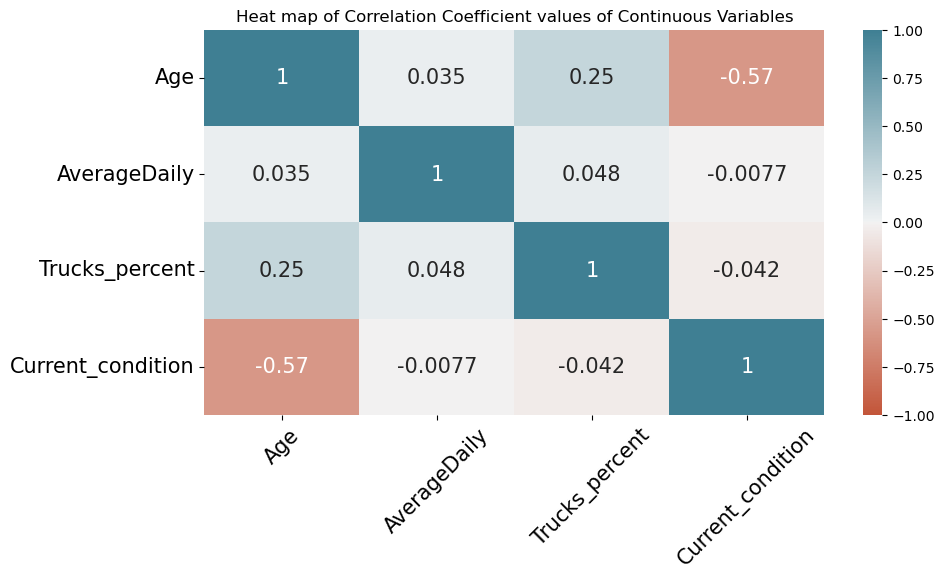

In [16]:
columns = ['Age', 'AverageDaily', 'Trucks_percent', 'Current_condition']
continous_var = bridges[columns]

fig,ax = plt.subplots(1,1, figsize=(10,5))
sns.heatmap(continous_var.corr(), vmin=-1, vmax=1, cmap=sns.diverging_palette(20, 220, as_cmap=True), 
           annot=True, ax=ax, annot_kws={"size": 15})
_y = plt.yticks(rotation=0, fontsize=15)
_x = plt.xticks(rotation=45, fontsize=15)
ax.set_title('Heat map of Correlation Coefficient values of Continuous Variables')


* To begin our analysis, I created a smaller DataFrame of the continuous variables we are interested in to compute our correlation coefficients for the variables.

* By inspecting the heatmap of the continuous variables, we immediately notice two metrics that stand out. One is that the `Current_condition` and `Age` variables are negatively correlated. From this, we can infer that the higher the age of the bridge, the worse its current condition is.

* The other takeaway is that we observe a slight positive correlation between the `Age` and `Trucks_percent` variables. From this, we can infer that as a bridge ages, it experiences more traffic, and thus we would naturally expect that due to the larger volume of traffic, we would see an increase in the percentage of lorries involved in that traffic.

* Outside of these two instances, the remaining correlation coefficients indicate that the majority of the combinations are not significantly correlated.

Text(0.5, 0.98, 'Scatter Matrix of Continous Variables')

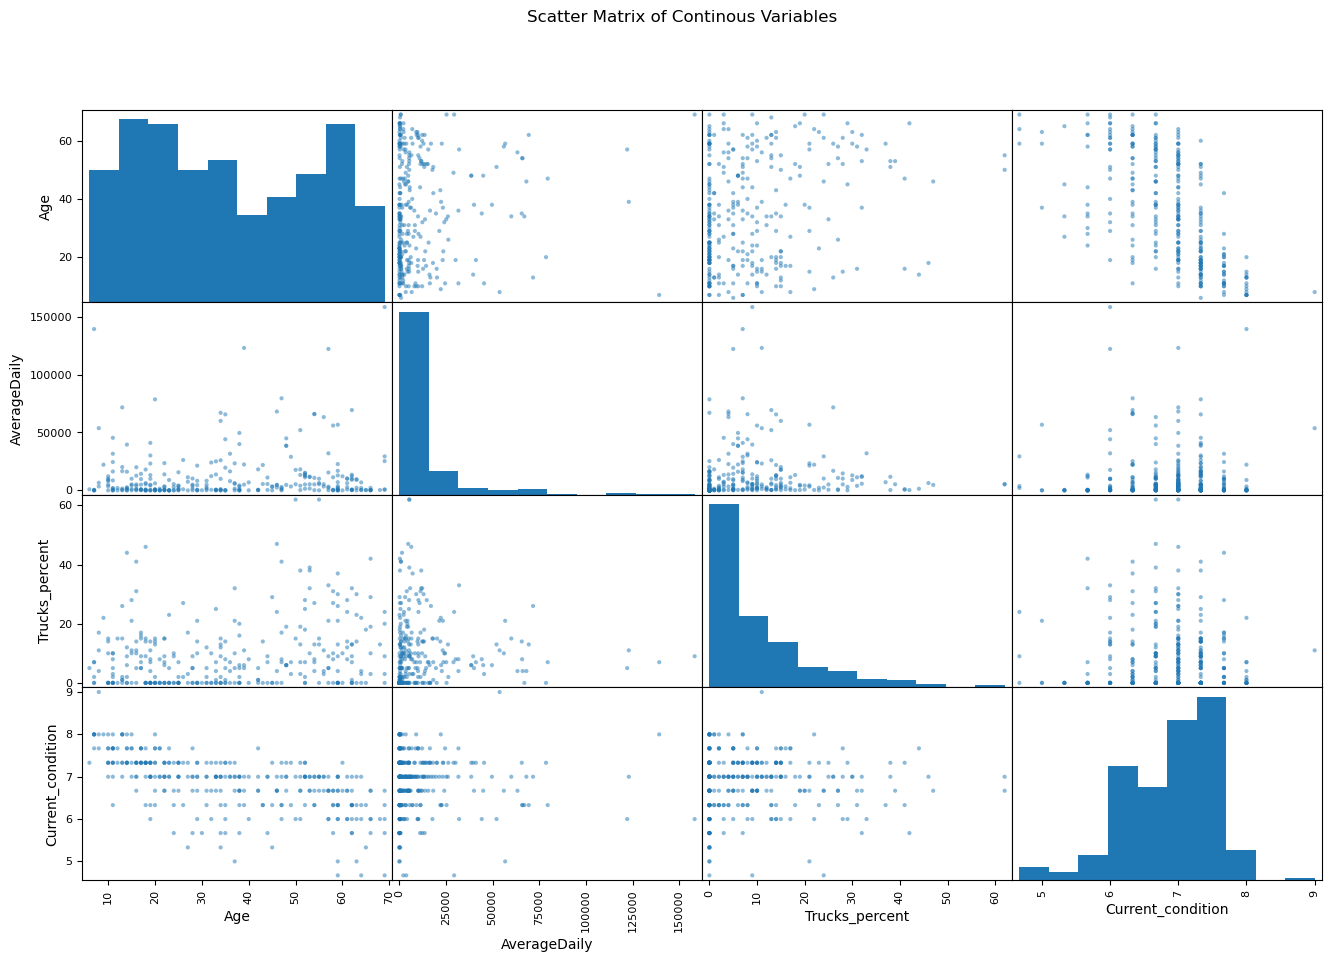

In [17]:
_a = pd.plotting.scatter_matrix(continous_var.sample(frac=0.01), figsize=(16,10))
plt.suptitle('Scatter Matrix of Continous Variables')

* Now we have presented a scatter matrix that plots our continuous variables against one another. From this, we can see that the relationships we assumed from the heatmap and correlation values are not straightforward to interpret.

* The two main pairs of continuous variables highlighted were the combinations of `Current_condition` and `Age`, and `Trucks_percent` and `Age`. To achieve this visualisation, we sampled just 1% of the dataset, as the sample contains a large number of data points. This ensures that while the relationships between variables are not instantly recognisable, sampling a smaller percentage of the dataset allows us to begin to see correlations between the specified variables due to a reduced density of data points.

* The scatter matrix provides a more robust way of inferring whether there is a relationship between the continuous variables. As we can see from the scatter plots, there may be slight relationships between variables, but these relationships are limited, and often, after a certain threshold, the connection between these variables becomes negligible.

### Section 2.2 Correlation of Categorical Variables

In this section the aim is to explore the relationship of the categorical variables to themselves, with the categorical variables being `Design` and `Material`.

This will be done with the following steps:

1. We will compute the joint proabilites of the categorical variables.
1. Compute conditional Proabilites of the categorical variables. 
1. Visualise both the joint and conditional probabilites with bar charts.

Text(0.5, 1.0, 'Probability of Material given Design of Bridge')

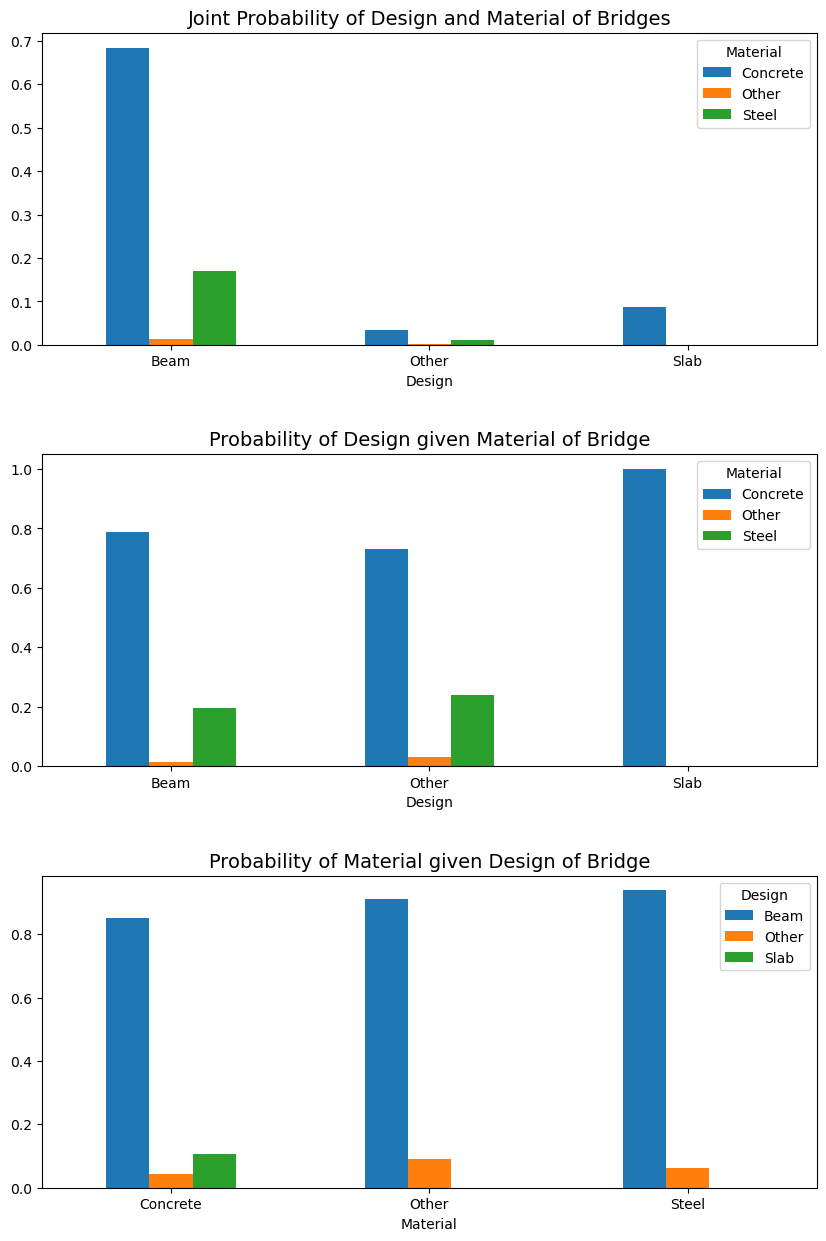

In [18]:
design_and_material = pd.crosstab(bridges.Design, [bridges.Material], normalize='all')
design_given_material = pd.crosstab(bridges.Design, [bridges.Material], normalize='index')
material_given_design = pd.crosstab(bridges.Material, [bridges.Design], normalize='index')

fig,(a1, a2, a3) = plt.subplots(3,1, figsize=(10,15), sharey=False, sharex=False)
fig.subplots_adjust(hspace=0.35)

design_and_material.plot(kind='bar', subplots=False, ax=a1, rot=0)
a1.set_title('Joint Probability of Design and Material of Bridges', fontsize=14)

design_given_material.plot(kind='bar', subplots=False, ax=a2, rot=0, stacked=False)
a2.set_title('Probability of Design given Material of Bridge', fontsize=14)

material_given_design.plot(kind='bar', subplots=False, ax=a3, rot=0, stacked=False)
a3.set_title('Probability of Material given Design of Bridge', fontsize=14)


* In comparing the categorical variables, I have chosen to illustrate this with joint probabilities, as they provide insight into the likelihood of the material and the design of the bridge occurring together. In contrast, conditional probability gives us the likelihood of the material of the bridge being concrete, for example, when the design of the bridge is a slab.

* The reason I opted for joint probabilities is that they offer greater insight into the relationship between the `Design` and `Material` categories by normalising these categories into numerical form, allowing for analysis to occur.

* Based on the joint probabilities and visualisations provided, we can interpret the relationships in the categories as follows: we have a high joint probability value for the use of concrete across all types of bridge designs. Specifically, for concrete, the value is 0.68, which indicates a strong relationship and preference for using concrete when constructing beam bridges.

* We observe minimal usage of other material types and, in general, other bridge types as well. This could be because concrete is perceived as the best material for building bridges compared to others, due to factors such as a lower need for constant maintenance and a slower rate of deterioration. Additionally, with the less frequent use of other bridge types, the need for alternative materials is less pronounced, which is why we see a dominance of concrete in beam-type bridges.

* When investigating the conditional probabilities of the design of a bridge given that the material is concrete, we find that all designs of bridges have a significantly higher probability of using concrete than if any other type of material were employed. This suggests that concrete has overwhelmingly become the material of choice for all bridge types.

* In the scenario of conditional probabilities, where knowing the type of bridge allows us to infer the material used, we again see that concrete is the overwhelming choice, except for bridge types labelled as 'Other'. The reason concrete may not be used for these 'Other' designs could be related to the bridge's purpose. Concrete is often preferred for longer bridges that will experience constant use, while 'Other' bridges might be intended for lower traffic, thus not requiring the physical properties provided by concrete. Additionally, the length of the bridge may also be a factor, as the cost of concrete can be higher than that of other materials, making it less sensible to spend more on a bridge that may not be used as frequently.

### Section 2.3 Relationship between Predictor and Target variables

In this section the aim is to explore the relationship between the predictor variables and the target variable:

* With our predictor variables being a mixture of categorical and continous variables we will have to employ different methods that allow for comparison across different variable types. The predictor variables are `Age`, `AverageDaily`, `Trucks_percent`, `Design`, `Material`  with the target variable being `Current_condition`.

This will be done with the following steps:

1. To compare the catgegorical predictor variable  with the continous target variable I have employed the use of a box plot to visulise this.
1. To accompany this we have also provided summary statistics for the current_conditon  across all the category values within the Design and Material Variables.


#### Section 2.3.1 Relationship between Categorical (predictor) and Target variables

In this section the aim is to explore the relationship between the categorical predictor variables and the target variables

* This section will primarily focus on exploring the relationship of the `Current_condition` variable with `Design` and `Material`.

This will be done with the following techniques:

1. To compare the catgegorical predictor variable  with the continous target variable I have employed the use of a box plot to visulise this.
1. To accompany this we have also provided summary statistics for the `current_conditon`  across all the category values within the Design and Material variables.
1. A KDE distribution will also be shown to accompany this.


Text(0, 0.5, 'Current Condition Rating')

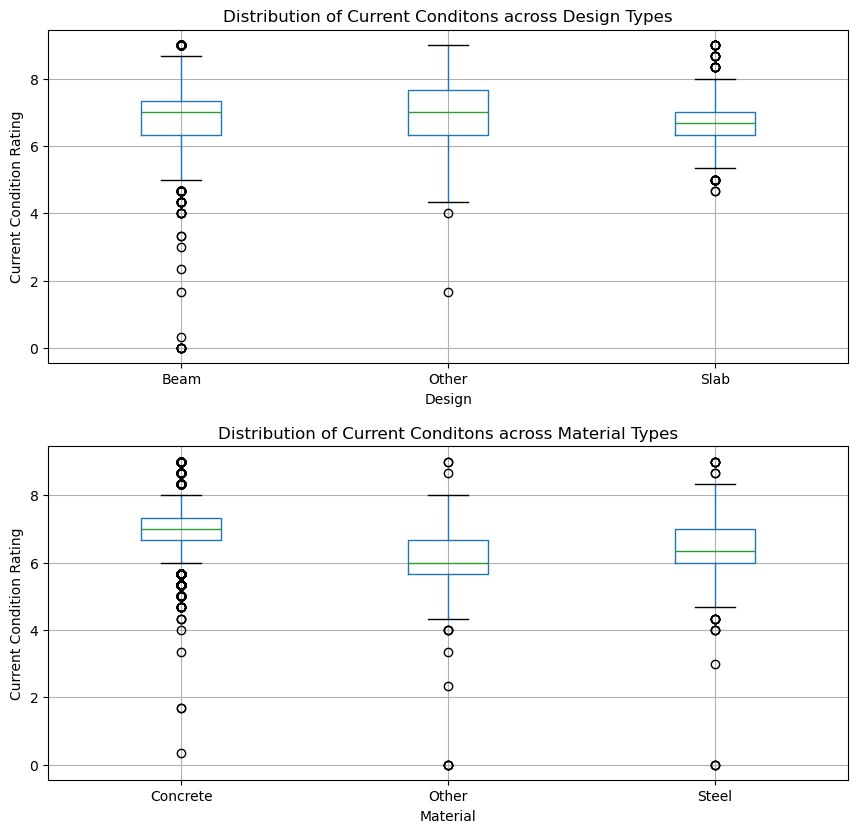

In [19]:
fig, (b1, b2) = plt.subplots(2,1, figsize=(10,10))
plt.subplots_adjust(hspace = 0.25)

bridges.boxplot(column='Current_condition', by='Design', ax=b1)
bridges.boxplot(column='Current_condition', by='Material', ax=b2)


fig.suptitle('')
[a.set_title('') for a in [b1, b2]]

b1.set_title('Distribution of Current Conditons across Design Types')
b1.set_ylabel('Current Condition Rating')
b2.set_title('Distribution of Current Conditons across Material Types')
b2.set_ylabel('Current Condition Rating')

* The box plot shows that across the different values in the design category, the behaviour of the current condition is not significantly impacted, as the different values in the categories overlap. This suggests that, regardless of the type of design, the current condition rating is not greatly influenced by this factor.

* In contrast, the box plot comparing the current condition against the categories in the material category provides more information, as there is less overlap of current condition values across the different material types. This suggests that the material used to construct the bridge does have an influence on the current condition values. We observe that for certain materials, not only is there a lower mean, but also lower quartile ranges.

* As noted in the previous section, we have discovered that, regardless of the design of the bridge, the material chosen is overwhelmingly concrete. This explains why we might not see much influence from the design variable on the current condition rating. It also helps to clarify why we see a wider range of quartile values for other materials: there are fewer bridges made from those materials, leading to a broader distribution of values, with some exhibiting very good current conditions and others not.

In [20]:
grpbydesign = bridges.groupby(by='Design', dropna=False, observed = False)
grpbymaterial = bridges.groupby(by='Material', dropna=False, observed = False)

def describeBy(groups, columns):
    for (index,grp) in groups:
        print('\nGroup', index)
        print('------------------')
        print(grp.loc[:,columns].describe())

describeBy(grpbymaterial, ['Current_condition'])

describeBy(grpbydesign, ['Current_condition'])


Group Concrete
------------------
       Current_condition
count       23958.000000
mean            6.959346
std             0.574317
min             0.330000
25%             6.670000
50%             7.000000
75%             7.330000
max             9.000000

Group Other
------------------
       Current_condition
count         457.000000
mean            6.003764
std             0.996958
min             0.000000
25%             5.670000
50%             6.000000
75%             6.670000
max             9.000000

Group Steel
------------------
       Current_condition
count        5382.000000
mean            6.431693
std             0.613633
min             0.000000
25%             6.000000
50%             6.330000
75%             7.000000
max             9.000000

Group Beam
------------------
       Current_condition
count       25852.000000
mean            6.852576
std             0.620282
min             0.000000
25%             6.330000
50%             7.000000
75%             7.33

* Above we have created two dataframes by partitioning the bridges dataframe one for the `Design` category and the other for the `Material` category

* Using the partioned dataframes we created, we were able to produce summary statistics for all the different different category values to provide greater definition to the visualisation seen in the box plot

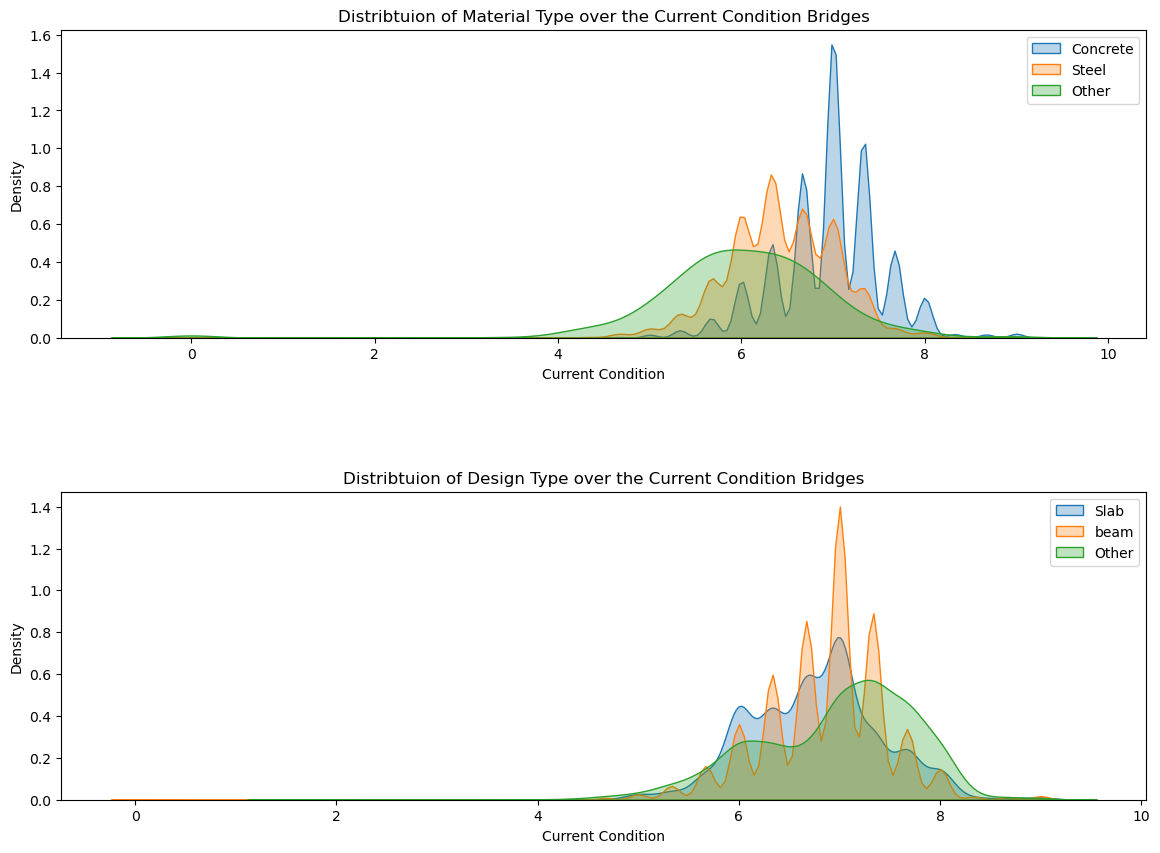

In [21]:
d_concrete = grpbymaterial.get_group('Concrete')
d_steel = grpbymaterial.get_group('Steel')
d_other_material = grpbymaterial.get_group('Other')

d_slab = grpbydesign.get_group('Slab')
d_beam = grpbydesign.get_group('Beam')
d_other_design = grpbydesign.get_group('Other')

fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(14,10))
fig.subplots_adjust(hspace=0.5)
var = 'Current_condition'

sns.kdeplot(data=d_concrete[var], label='Concrete', ax=ax1, alpha=0.3, fill=True)
sns.kdeplot(data=d_steel[var], label='Steel', ax=ax1, alpha=0.3, fill=True)
sns.kdeplot(data=d_other_material[var], label='Other', ax=ax1, alpha=0.3, fill=True)

sns.kdeplot(data=d_slab[var], label='Slab', ax=ax2, alpha=0.3, fill=True)
sns.kdeplot(data=d_beam[var], label='beam', ax=ax2, alpha=0.3, fill=True)
sns.kdeplot(data=d_other_design[var], label='Other', ax=ax2, alpha=0.3, fill=True)

ax1.set_xlabel('Current Condition')
ax1.set_title('Distribtuion of Material Type over the Current Condition Bridges')
ax1.legend()
ax2.set_xlabel('Current Condition')
ax2.set_title('Distribtuion of Design Type over the Current Condition Bridges')
ax2.legend()
# ax1.

* We have a KDE (Kernel Density Estimate) plot above that allows us to compare the categorical variables with our target variable.

* This plot enables us to visualise the distribution of current condition values for the different categories in the `Design` and `Material` variables.

* By analysing the shapes and positions of the KDE plots, we can make inferences about the relationship between the predictor variables and the target variable, providing greater insight into how the design and material of the bridge may affect the current condition rating.

* When analysing the KDE for `Design`, we might infer that the relationship between the design type and current condition is not significant, as the values for the different types seem to be distributed across similar ranges. Thus, we might assume that, regardless of the design of the bridge, the current condition rating would not be heavily affected.

* However, when we consider the KDE for `Material`, we begin to see some differences in the range of values for the current condition. Initially, we might infer that this indicates the material of the bridge does have an effect on the current condition rating.

* When scrutinising this plot, it is important to consider the fact that the different categories do not contain the same number of data points, which might influence the distribution of the range of values, especially if a category has a large number of extreme values at either end of the rating spectrum.

#### Section 2.3.2 Relationship between Predictor variables

In this section the aim is to explore the relationship between the Continuous Predictors and their categorical counterparts.

* This section will primarily focus on exploring the relationship of the `Age`, `Trucks_percent` and `AverageDaily` variables with `Design` and `Material`.
* In this section we will not compare the relationship of our continous predictors as we have done that in **Section 2.1** above.

This will be done with the following techniques:

1. To compare the catgegorical predictor variable  with the continous target variable I have employed the use of a box plot to visulise this.
1. To accompany this we have also provided summary statistics for the the continous predictor variables across all the category values within the Design and Material Variables.



Text(0, 0.5, 'Age')

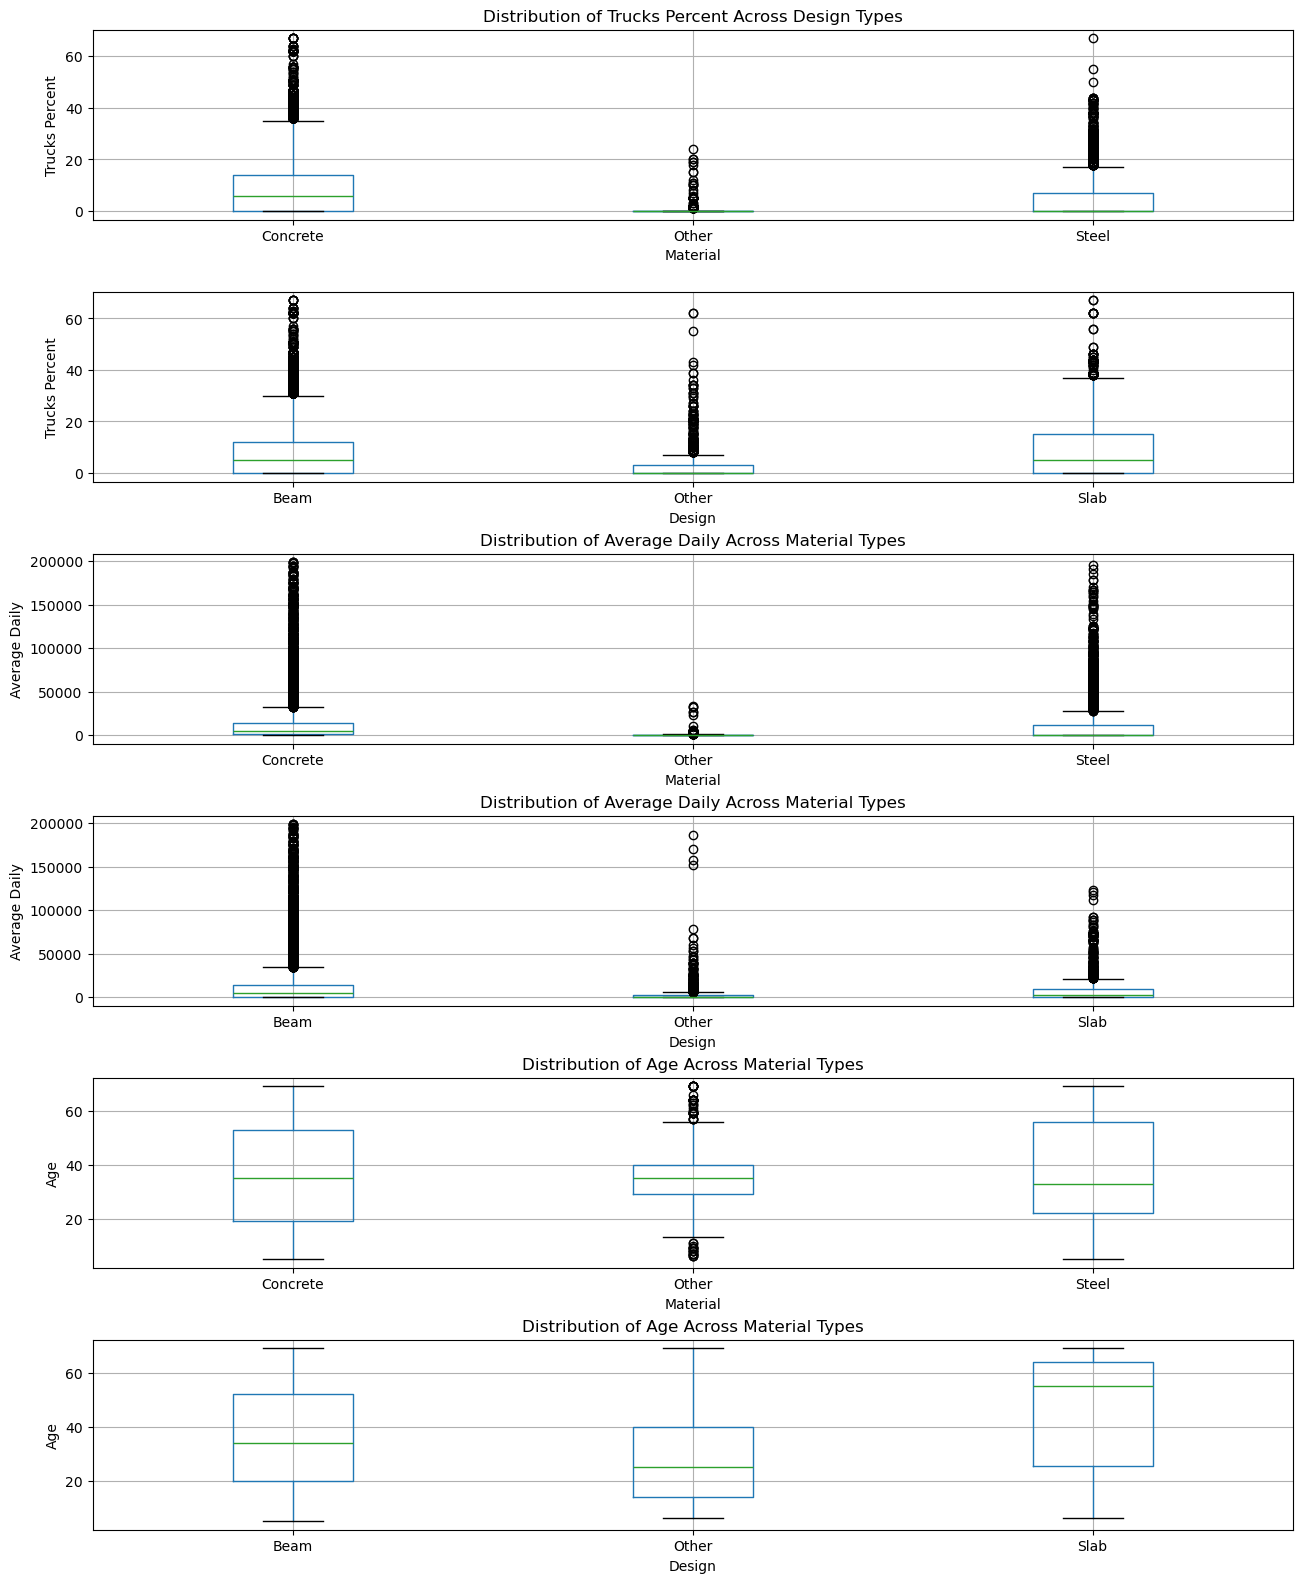

In [22]:
fig, (a1, a2, a3, a4, a5, a6) = plt.subplots(6,1, figsize=(15,20))
fig.subplots_adjust(hspace=0.38)

bridges.boxplot(column='Trucks_percent', by='Material', ax=a1) 
bridges.boxplot(column='Trucks_percent', by='Design', ax=a2)
bridges.boxplot(column='AverageDaily', by='Material', ax=a3)
bridges.boxplot(column='AverageDaily', by='Design', ax=a4)
bridges.boxplot(column='Age', by='Material', ax=a5)
bridges.boxplot(column='Age', by='Design', ax=a6)

fig.suptitle('')
[a.set_title('') for a in [a1, a2, a3, a4, a5, a6]]

a1.set_title('Distribution of Trucks Percent Across Material Types')
a1.set_ylabel('Trucks Percent')
a1.set_title('Distribution of Trucks Percent Across Design Types')
a2.set_ylabel('Trucks Percent')
a3.set_title('Distribution of Average Daily Across Material Types')
a3.set_ylabel('Average Daily')
a4.set_title('Distribution of Average Daily Across Material Types')
a4.set_ylabel('Average Daily')
a5.set_title('Distribution of Age Across Material Types')
a5.set_ylabel('Age')
a6.set_title('Distribution of Age Across Material Types')
a6.set_ylabel('Age')

In [23]:
describeBy(grpbymaterial, ['Age', 'Trucks_percent', 'AverageDaily'])

describeBy(grpbydesign, ['Age', 'Trucks_percent', 'AverageDaily'])


Group Concrete
------------------
                Age  Trucks_percent   AverageDaily
count  23958.000000    23958.000000   23958.000000
mean      36.093580        9.176142   12388.850488
std       18.464548       10.453795   22092.624490
min        5.000000        0.000000       0.000000
25%       19.000000        0.000000     710.000000
50%       35.000000        6.000000    4519.500000
75%       53.000000       14.000000   13500.000000
max       69.000000       67.000000  198620.000000

Group Other
------------------
              Age  Trucks_percent  AverageDaily
count  457.000000      457.000000    457.000000
mean    35.120350        0.932166    901.330416
std     12.879364        2.948720   3481.387791
min      6.000000        0.000000      2.000000
25%     29.000000        0.000000     50.000000
50%     35.000000        0.000000    100.000000
75%     40.000000        0.000000    390.000000
max     69.000000       24.000000  33500.000000

Group Steel
------------------
          

* Based on the box plots and summary statistics for the categorical variables, we observe very minimal change in the summary statistics for the different categories of the continuous variables. What we can infer from this is that the predictor variables are not heavily correlated and there is a minimal relationship between them.

* The overlap of the box plots also confirms this inference. If the positions of the box plots were significantly different depending on which categories we observed, we might infer that the variables have some semblance of a relationship. However, as this is not the case, it reinforces our initial analysis that the predictor variables are not significantly correlated.

### Section 2.4: Preliminary conclusions

In this section, We will look to provide some conclusions based on the exploratory analysis carried out above to answer the questions proposed at the beginning of this analysis

The questions being:

* How well the proposed variables can predict the bridge condition.
* Which of the proposed variables has more influence on the current condition.


* Based on the exploratory analysis carried out above, we can come to a preliminary conclusion that out of all the predictor variables, the two variables that seem to be the best predictors of bridge condition and have an increased influence on the current condition are the `Age` and `Material` variables.

* To explain this conclusion, we look at the analysis of the relationship between our predictor variables and the target variable. From the comparison, we found that the combination with the highest correlation coefficient, a value of -0.57, was `Age` and `Current_condition`. This value signifies that the predictor and target in this case are negatively correlated, but it also allows us to infer that, among the continuous predictor variables, `Age` might have the most pronounced effect in indicating the `Current_condition` of the bridge. It can also help make preliminary predictions about the condition of the bridge.

* In terms of the `Material` predictor, I chose to use the summary statistics of the `Current_condition` across the different categories of material to support this conclusion. We found that depending on the material chosen, there was often a wider distribution of `Current_condition` values. This suggests that the material of the bridge has a pronounced effect on the `Current_condition` rating, and due to its influence on these values, it can help us predict future `Current_condition` values.

* However, to dispel or confirm these predictions, we will carry out a linear regression to either validate this conclusion or provide us with an alternative answer.

## Section 3: Regression Modelling

In this section, the aim is to look at the effect of the predictor variable on the target variable:

* This is to be done with the use of a linear regression model 
* We will Obtain the R2 value and the error values  
* Finally we will attempt to answer the questions proposed by the Texas Department of Transportion 


## Section 3.1 Fitting the Regression Model and Obtaining Beta Coefficients

The aim of this section is to fit a regression model using our predictor variables and target variable from which we will obtain the beta values for all predictors.

From this section we will gain the R2 value and the different beta coefficients for all out predictor variables.

In [24]:
design_d = pd.get_dummies(bridges.Design, drop_first= False, dtype = int)
material_d = pd.get_dummies(bridges.Material, drop_first= False, dtype = int)

To perform regression with our categorical predictor variables, above we converted them to binary objects in order to use them in the regression analysis

In [25]:
y = bridges.Current_condition
X = np.column_stack((bridges.Age,bridges.AverageDaily, bridges.Trucks_percent, design_d.Other, design_d.Slab,design_d.Beam,
                      material_d.Other, material_d.Steel, material_d.Concrete))

reg = LinearRegression().fit(X, y)

beta_Age = reg.coef_[0]
beta_AverageDaily = reg.coef_[1]
beta_Trucks = reg.coef_[2]
beta_d_other = reg.coef_[3]
beta_slab = reg.coef_[4]
beta_beam = reg.coef_[5]
beta_m_other = reg.coef_[6]
beta_steel = reg.coef_[7]
beta_concrete = reg.coef_[8]

print('The R2 coefficient of determination is %4.3f' % reg.score(X, y))
print('The intercept is %4.1f' % reg.intercept_)
print('The regression coefficients are:', reg.coef_)

The R2 coefficient of determination is 0.453
The intercept is  7.2
The regression coefficients are: [-1.98456054e-02 -1.99439892e-07  2.00999313e-03  4.62293154e-03
 -5.67864639e-03  1.05571485e-03 -4.76303257e-01 -8.90236728e-03
  4.85205624e-01]


## Section 3.2 Comparing the Coefficients

In this section the aim the following aims are: 

* Compare the Beta coefficients of our predictors with the aim of deducing which of the predictors have the most pronounced influenced on the target variable
* Deduce the range of our predictor variables
* Deducing the rate of change of target variable depending on the predictor 

In [26]:
Age_range = bridges.Age.quantile(0.9) - bridges.Age.quantile(0.1)
AverageDaily_range = bridges.AverageDaily.quantile(0.9) - bridges.AverageDaily.quantile(0.1)
Trucks_range = bridges.Trucks_percent.quantile(0.9) - bridges.Trucks_percent.quantile(0.1)
Design_other = design_d.Other.quantile(0.9) - design_d.Other.quantile(0.1)
Design_slab = design_d.Slab.quantile(0.9) - design_d.Slab.quantile(0.1)
Design_beam = design_d.Beam.quantile(0.9) - design_d.Beam.quantile(0.1)
Material_other = material_d.Other.quantile(0.9) - material_d.Other.quantile(0.1)
Material_steel = material_d.Steel.quantile(0.9) - material_d.Steel.quantile(0.1)
Material_concrete = material_d.Concrete.quantile(0.9) - material_d.Concrete.quantile(0.1)
Current_condition_range = bridges.Current_condition.quantile(0.9) - bridges.Current_condition.quantile(0.1)

print ('The change in the current conditon of a bridge (as a percent of its range) given by the age coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Age * Age_range) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Average Daily coefficient (over its range) is %4.1f percent'
       % (100 * (beta_AverageDaily * AverageDaily_range) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Trucks Percent coefficient (over its range) is %4.1f percent'
       % (100 * (beta_Trucks * Trucks_range) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Design: Beam coefficient (over its range) is %4.1f percent'
       % (100 * (beta_beam  * Design_beam) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Design: Other coefficient (over its range) is %4.1f percent'
       % (100 * (beta_d_other * Design_other) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Design: Slab coefficient (over its range) is %4.1f percent'
       % (100 * (beta_slab * Design_slab) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Material: Other coefficient (over its range) is %4.1f percent'
       % (100 * (beta_m_other * Material_other) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Material: Steel coefficient (over its range) is %4.1f percent'
       % (100 * (beta_steel * Material_steel) / Current_condition_range))

print ('The change in the current condition of a bridge (as a percent of its range) given by the Material: Concrete coefficient (over its range) is %4.1f percent'
       % (100 * (beta_concrete * Material_concrete) / Current_condition_range))


The change in the current conditon of a bridge (as a percent of its range) given by the age coefficient (over its range) is -59.4 percent
The change in the current condition of a bridge (as a percent of its range) given by the Average Daily coefficient (over its range) is -0.4 percent
The change in the current condition of a bridge (as a percent of its range) given by the Trucks Percent coefficient (over its range) is  2.6 percent
The change in the current condition of a bridge (as a percent of its range) given by the Design: Beam coefficient (over its range) is  0.1 percent
The change in the current condition of a bridge (as a percent of its range) given by the Design: Other coefficient (over its range) is  0.0 percent
The change in the current condition of a bridge (as a percent of its range) given by the Design: Slab coefficient (over its range) is -0.0 percent
The change in the current condition of a bridge (as a percent of its range) given by the Material: Other coefficient (over 

## Section 3.3 Prediction and the Error Distribution

In this section the aims are: 

* To show the distribution of the error values
* To calculate the RMSE 
* Provide a visualisation of the predicted values against the actual values. 


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Root of the mean squared error: 0.47


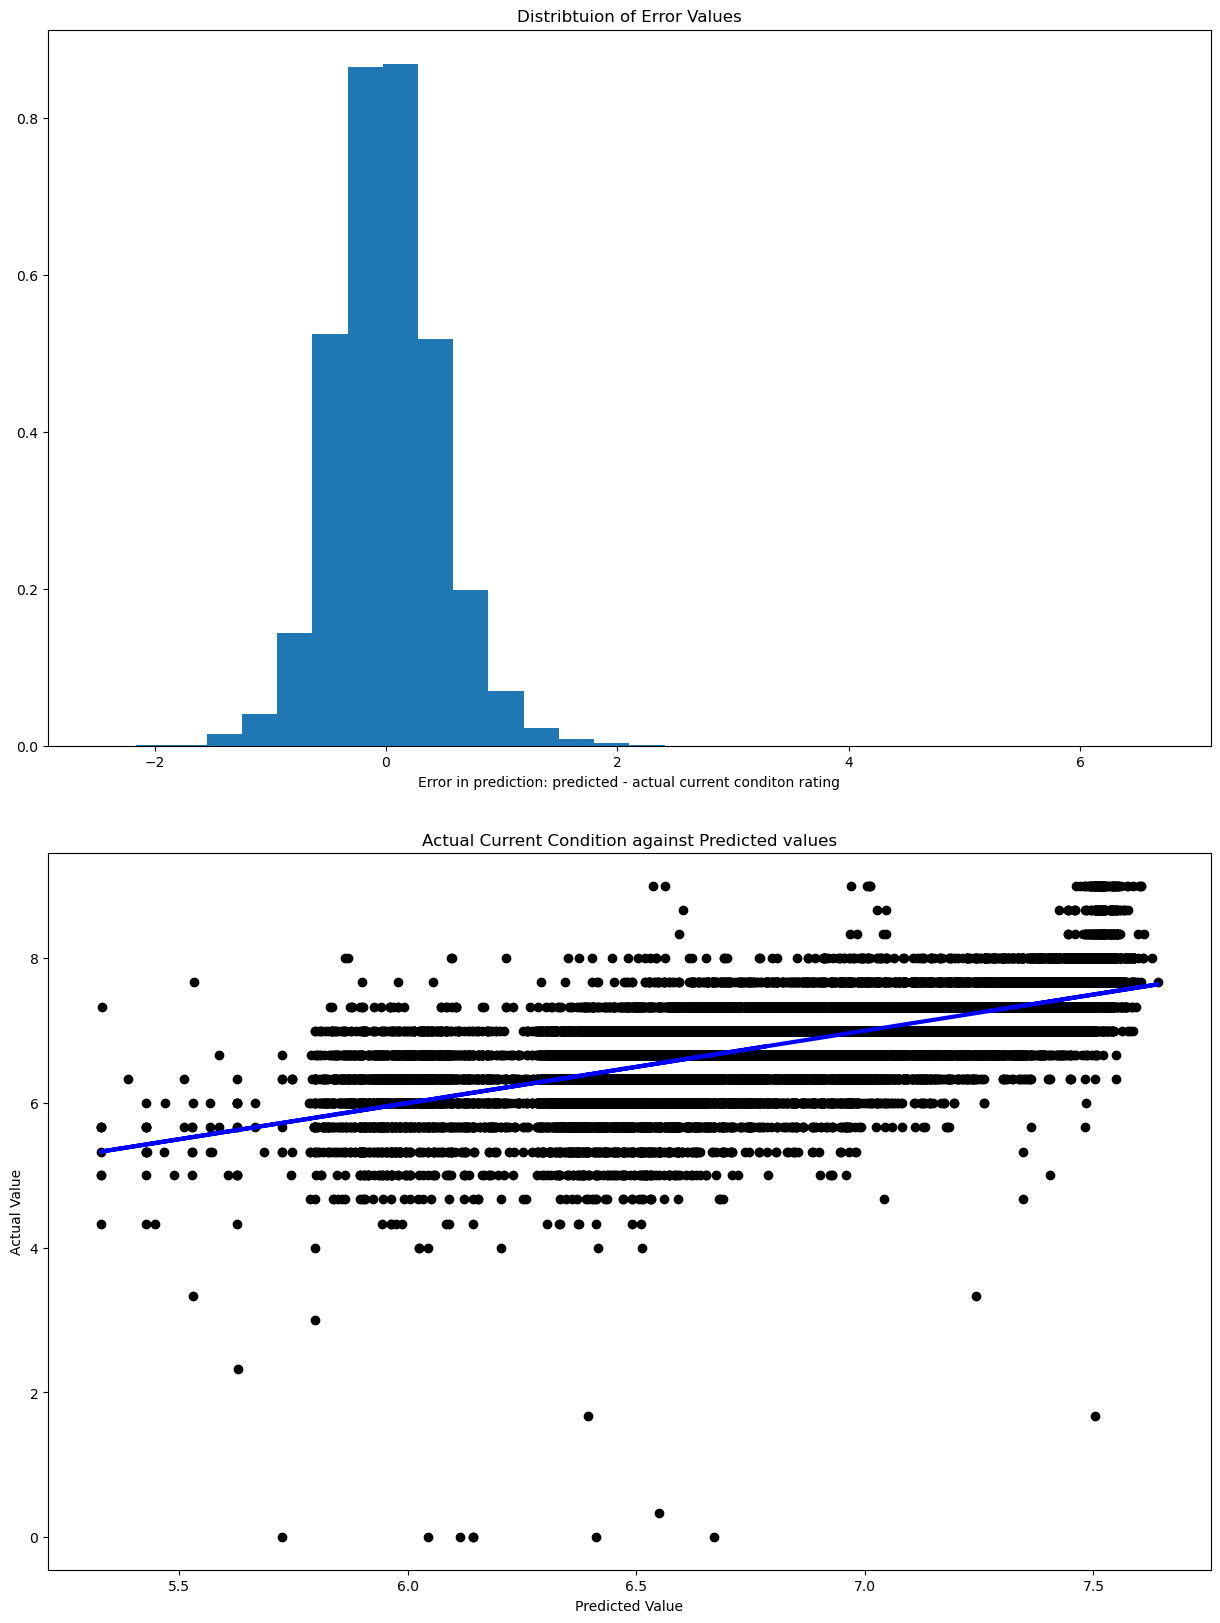

In [27]:
y_hat = reg.predict(X)

fig, (a1,a2) = plt.subplots(2, 1, figsize=(15,20))
plt.subplots_adjust(hspace=0.15)
residuals = y_hat - y
a1.hist(residuals, bins=30, density=True)
a2.scatter(y_hat, y,  color='black')
a2.plot(y_hat, y_hat, color='blue', linewidth=3)

a2.set_title('Actual Current Condition against Predicted values')
a2.set_xlabel('Predicted Value')
a2.set_ylabel('Actual Value')
a1.set_xlabel('Error in prediction: predicted - actual current conditon rating')
a1.set_title('Distribtuion of Error Values')

print('Root of the mean squared error: %.2f'% mean_squared_error(y, y_hat, squared=False))

* When looking at the distribution of error values, we see that a minimal distribution of error values indicates reduced variability in the predictions made by the model. This is characterised by the narrow range of values seen in the distribution, which is also an indicator of more reliable predictions.

* A narrow range in the distribution suggests that the model's predictions are close to the actual values. This implies that the model is a good fit, as it demonstrates that the model captures the underlying patterns between the predictor variables and the target variable.

## Section 3.4 Final Conclusions and Potential for further analysis

In the section the following aims are:

* Provide the final conclusions to the question propsed at the start of this analysis by the Texas Department of Transportation.
* Explain the significance of the R2, RMSE, Beta coefficients
* Propose any further analysis

* The R2 coefficient is a measure that tells us how well our regression model explains the variability of our target variable. For our model, we obtained an R2 value of 0.453. This indicates that our model does not fit our dataset perfectly, but it also shows that 45% of the variability in our target variable is influenced by our predictor variables. Conversely, this means that 55% of the variability in the target variable is not accounted for.

* To further comment on the error values, we calculated the RMSE (Root Mean Square Error). This value measures the magnitude of errors between the actual current condition values and the predicted values. For our calculation, we obtained a value of 0.47, which provides multiple insights about performance. Firstly, it indicates that our model is adept at predicting values that are close to the actual values. Secondly, it informs us that the model performs well on the training dataset, giving us confidence in its performance.

* From our regression modelling, we obtained the beta coefficients for all the predictors. The beta coefficients measure the amount of influence a certain predictor has on the target variable. When comparing the beta coefficients to each other, we see that, aside from the `Age` and the coefficients for the `Material` category, the values are quite small. This indicates that, outside of these two predictors, the remaining variables have significantly lower influence on the current condition of a given bridge.

* At the end of our exploratory analysis, I made a preliminary conclusion that the two predictors with the greatest influence on predicting our current condition values are `Age` and `Material`. Looking at the comparison of the change in the target variable as a percentage of the range for each predictor, we see that the predictor with the largest influence on the target variable is `Age`. Overall traffic levels, the design of the bridge, and the materials used in the construction of the bridge seem to have a minimal impact on the target variable. This disproves my preliminary conclusion that both `Age` and `Material` have a significantly pronounced effect on the current condition of the bridge.

* After considering the various analyses that have been carried out, I conclude that the proposed variables do not effectively predict the condition of the bridge. The reason I have arrived at this conclusion is based on the R2 value. Even though we have an error distribution indicating good model performance, the R2 value and the beta coefficients are more indicative of the predictive ability of our chosen variables. The majority of the beta coefficients are quite low, indicating low influence on the target variable, which may also reflect the predictors' ability to inform us about future current condition ratings. However, it is worth mentioning that the `Age` and `Material` variables appear to be better predictors of current condition than the other predictors used.

* If we were to further analyse our dataset, I would suggest changing the predictor variables. As we have seen, the `AverageDaily`, `Trucks_percent`, and `Design` predictors do not provide insight into the questions proposed at the beginning of the analysis. I would recommend looking at the `Urban`, `Status`, and `Future_traffic` variables, as I believe these could be greater indicators of the current condition.